In [47]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.spatial.distance import cdist
style.use("ggplot")
%matplotlib inline

# K-Means Clustering Example
In this example notebook, you will see how to implement K-Means Clustering in Python using Scikit-Learn and Pandas. 
Adapted from https://pythonprogramming.net/flat-clustering-machine-learning-python-scikit-learn/

## Step 1:  Get Data:
The first step is to prepare or generate the data.  In this dataset, the observations only have two features, but K-Means can be used with any number of features.  Since this is an unsupervised example, it is not necessary to have a "target" column.

In [8]:
data = pd.DataFrame([[1, 2],
              [5, 8],
              [1.5, 1.8],
              [8, 8],
              [1, 0.6],
              [9, 11]], columns=['x','y'])
print( data )

     x     y
0  1.0   2.0
1  5.0   8.0
2  1.5   1.8
3  8.0   8.0
4  1.0   0.6
5  9.0  11.0


## Step 2:  Build the Model:
Much like the supervised models, you first create the model then call the `.fit()` method using your data source.  The model is now populated with both your centroids and labels.  These can be accessed via the `.cluster_centers_` and `labels_` properties respectively.

You can view the complete documentation here: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

K-Means also has a `.predict()` method which can be used to predict the label for an observation.

In [9]:
kmeans = KMeans(n_clusters=2).fit(data)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(centroids)
print(labels)

[[ 7.33333333  9.        ]
 [ 1.16666667  1.46666667]]
[1 0 1 0 1 0]


In [10]:
test = pd.DataFrame([[4,2]])

kmeans.predict(test)
print(test)

   0  1
0  4  2


# Visualizing the Clusters
The code below visualizes the clusters.  

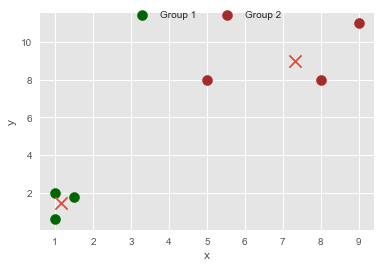

In [11]:
data['labels'] = labels

#plt.plot(data, colors[data['labels'], markersize = 10)

group1 = data[data['labels']==1].plot( kind='scatter', x='x', y='y',  s=100, color='DarkGreen', label="Group 1" )
group2 = data[data['labels']==0].plot( kind='scatter', x='x', y='y', s=100,color='Brown', ax=group1, label="Group 2" )
group1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()

# Clustering with Real Data
Now that you've tried K-means on some generated data, let's try it on some real data and see what we can produce. As before the first step is to read in the data into a DataFrame.  

We will be using this data later, but the dataset consists of approximately 6000 domains--5000 of which were generated by various botnets and 1000 are from the Alexa 1 Million.  The columns are:

* `dsrc`:  The source of the domain
* `domain`:  The actual domain
* `length`:  The length of the domain
* `dicts`:  Percentage containing dictionary words
* `entropy`:  The entropy of the domain
* `numbers`:  The number of digits in the domain
* `ngram`:  Different n-grams which appear in the domain (?)

In [14]:
data = pd.read_csv('../../Data/dga-full.csv')
data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram
6153,cryptolocker,ridgkddpiqhlfpp,15,0.733333,3.139572,0,1.982271
38549,nivdort,gladbegan,9,1.000000,2.725481,0,5.158362
45761,alexa,inthe7heaven,12,0.916667,2.855389,1,9.564581
26558,necurs,ceqhmkkavcnpihr,15,0.600000,3.506891,0,0.000000
45453,alexa,accountservergroup,18,1.000000,3.461320,0,31.378874


## Scaling the Data
Since clustering relies on measuring distances between objects it is important that all data points be on the same scale.  There are various methods for doing this, which are beyond the scope of this class, however, for this example, we will use scikit-learn's `StandardScaler` to accomplish this.  (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

The StandardScaler transforms each column by:
* Subtracting from the element in each row the mean for each feature (column) and then taking this value and
* Dividing by that feature's (column's) standard deviation.

Scikit-learn has a transformer interface which is very similar to the other scikit-learn interfaces.  The basic steps are:
1.  Create the Scaler object
2.  Using the feature matrix, call the `.fit()` method to "train" the Scaler
3.  Use the `.transform()` method to scale the data.

**NOTE**: When using a Scaler, it is important to train the scaler on your data, and use this trained scalers on any future predictions. 

In [15]:
feature_columns = ['length', 'dicts','entropy','numbers','ngram']
scaled_feature_columns = ['scaled_length', 'scaled_dicts','scaled_entropy','scaled_numbers','scaled_ngram']

In [16]:
#Step 1:  Create the scaler
scaler = StandardScaler()

#Steps 2 & 3:  Fit the scaler and transform this data
scaled_df = scaler.fit_transform(data[feature_columns])

#Put the scaled data into a dataframe
scaled_df = pd.DataFrame(scaled_df, columns=scaled_feature_columns)

Take a look at the data and you'll see that the data is now all scaled consistently. 

In [17]:
scaled_df.sample(10)

,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
23986,-0.539668,-0.104976,-0.551102,-0.498385,-0.208014
14404,1.691776,-1.310116,1.167421,2.159913,-0.811719
50939,-1.064714,1.144799,-1.227875,-0.498385,-0.012799
8758,-0.277145,-0.970205,-0.090780,-0.498385,-0.722434
43023,-0.802191,1.144799,-0.492925,-0.498385,2.525480
30652,0.641685,0.044997,0.367386,-0.498385,0.347134
12254,-0.145884,-1.604706,-0.428195,-0.498385,-0.811719
6838,-0.408407,-0.000828,-0.364669,-0.498385,0.426418
52012,-1.458498,1.144799,-2.127695,-0.498385,-0.484576
16192,1.297992,-0.944825,1.742915,0.451007,-0.431200


Finally for convenience, we're going to merge the scaled data with the non-scaled data.  

In [18]:
final_data = pd.merge( data, scaled_df, left_index=True, right_index=True)

### Your Turn!
Now that we have data that is suitable (maybe) for clustering, in the section below, perform K-Means clustering on this data set.  Initially, start out with 2 clusters and assign the cluster id as a column in your DataFrame.

Then do a `value_counts()` on the `dsrc` column for each cluster to see how the model divided the data.  Try various values for `k` to see how it performed.

Remember to use the scaled features ONLY for your clustering.  

In [19]:
## Your code here...

kmeans = KMeans(n_clusters=2).fit(final_data[scaled_feature_columns])

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(centroids)
print(labels)

[[ 1.56899145 -1.17177795  1.22510555  1.5429584  -0.63406745]
 [-0.49760996  0.3716326  -0.3885456  -0.4893535   0.20109624]]
[0 0 0 ..., 1 1 1]


In [20]:
final_data['dsrc'].value_counts()

cryptolocker    10000
alexa           10000
gameoverdga     10000
necurs          10000
nivdort          9978
bamital          2500
Name: dsrc, dtype: int64

In [21]:
final_data['cluster_id'] = kmeans.labels_

In [22]:
final_data['cluster_id'].value_counts()

1    39842
0    12636
Name: cluster_id, dtype: int64

In [23]:
final_data[final_data['cluster_id'] == 1]['dsrc'].value_counts()

cryptolocker    10000
alexa            9997
nivdort          9978
necurs           9860
gameoverdga         7
Name: dsrc, dtype: int64

In [24]:
final_data[final_data['cluster_id'] == 0]['dsrc'].value_counts()

gameoverdga    9993
bamital        2500
necurs          140
alexa             3
Name: dsrc, dtype: int64

In [25]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram,cluster_id
36882,nivdort,jumpcompe,9,1.000000,2.725481,0,5.579088,-0.802191,1.144799,-0.876255,-0.498385,0.232309,1
4278,cryptolocker,yegoeinaggtqbld,15,0.733333,3.456565,0,5.127856,-0.014622,0.411597,0.384852,-0.498385,0.147869,1
39406,nivdort,sickconsiderable,16,1.000000,3.500000,0,22.075126,0.116639,1.144799,0.459777,-0.498385,3.319250,1
38214,nivdort,musiclady,9,1.000000,3.169925,0,13.149060,-0.802191,1.144799,-0.109596,-0.498385,1.648895,1
11859,cryptolocker,ieowwxxwfwuha,13,0.000000,2.931209,0,0.000000,-0.277145,-1.604706,-0.521377,-0.498385,-0.811719,1


## Visualizing Performance
As we already know, it is difficult to measure the performance of clustering models since there usually is no known ground truth from which to evaluate your model.  However, there are two techniques which 

The K-Elbow Visualizer implements the “elbow” method of selecting the optimal number of clusters for K-means clustering. K-means is a simple unsupervised machine learning algorithm that groups data into a specified number (k) of clusters. Because the user must specify in advance what k to choose, the algorithm is somewhat naive – it assigns all members to k clusters even if that is not the right k for the dataset.

The elbow method runs k-means clustering on the dataset for a range of values for k (say from 1-10) and then for each value of k computes an average score for all clusters. By default, the distortion_score is computed, the sum of square distances from each point to its assigned center. Other metrics can also be used such as the silhouette_score, the mean silhouette coefficient for all samples or the calinski_harabaz_score, which computes the ratio of dispersion between and within clusters.

When these overall metrics for each model are plotted, it is possible to visually determine the best value for K. If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is the best value of k. The “arm” can be either up or down, but if there is a strong inflection point, it is a good indication that the underlying model fits best at that point. (http://www.scikit-yb.org/en/latest/api/cluster/elbow.html)

In python there is a module called `YellowBrick` which facilitates visualizing the K-Elbow score.  All of YellowBrick's visualizations follow essentually the same pattern:

1.  Create the Visualizer Object
2.  Call the `.fit()` method using the data
3.  Call the `.poof()` method to render the visualization

The snippet below demonstrates how to use the elbow method to visualize the clustering model's performance on this dataset.
```python
visualizer = KElbowVisualizer(KMeans(), k=(4,12))

visualizer.fit( feature_matrix ) 
visualizer.poof()
```

### Your Turn!
In the box below, create a visualization using the elbow method to see if there are any inflection points in the distortion score.

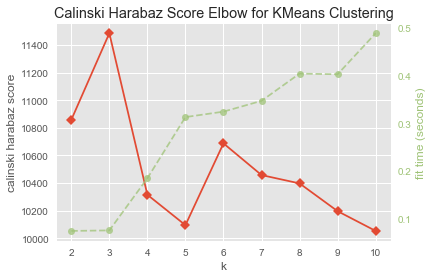

In [46]:
# Your code here...
visualizer = KElbowVisualizer( KMeans(), 
                              k=10,
                              metric='calinski_harabaz')

visualizer.fit(final_data[scaled_feature_columns].sample(10000))
visualizer.poof()

## Another Way to Visualize Clustering Performance
The Silhouette Coefficient is used when the ground-truth about the dataset is unknown and computes the density of clusters computed by the model. The score is computed by averaging the silhouette coefficient for each sample, computed as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. This produces a score between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering. (http://www.scikit-yb.org/en/latest/api/cluster/silhouette.html)


### Your Turn!
Using the YellowBrick `SilhouetteVisualizer`, try visualizing models with various values of `K`.

**Note**:  This visualization is quite expensive, so I recommend performing this using a sample o your original data.

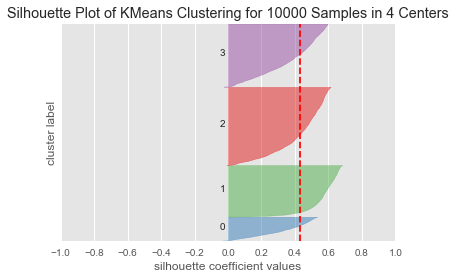

In [21]:
# Your code here...
visualizer = SilhouetteVisualizer( KMeans(n_clusters=4))

visualizer.fit(final_data[scaled_feature_columns].sample(10000))
visualizer.poof()